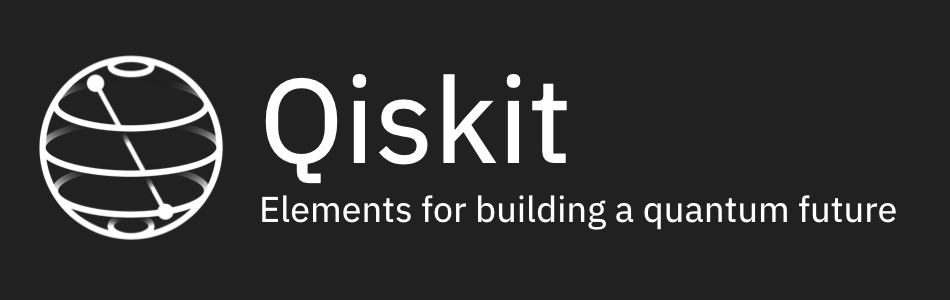

# Qiskit Aer: Pulse simulation of a backend model

This notebook shows how to use the Aer pulse simulator using a model generated from a backend. In particular, we run a Rabi experiment on the Armonk one qubit backend, then simulate the same experiment on the pulse simulator, calibrating the model parameters to reproduce the results from the real backend.



## Introduction

Import general libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root

Import `IBMQ` and `pulse`:

In [2]:
from qiskit import IBMQ

import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

Import `PulseSimulator` and `PulseSystemModel` for pulse simulation:

In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Rabi oscillations redux

In [4]:
provider = IBMQ.load_account()
armonk_backend = provider.get_backend('ibmq_armonk')

In [8]:
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

In [12]:
qubits = [0]

# exp configuration
exps = 64
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 1.0, exps)
drive_duration = 2048
drive_sigma = 256
drive_channels = [pulse.DriveChannel(0)]

rabi_scheds, xdata = rabi_schedules(drive_amps, 
                                          qubits, 
                                          drive_duration, 
                                          pulse_sigma = drive_sigma,
                                          drives=drive_channels, 
                                          inst_map=armonk_backend.defaults().instruction_schedule_map, 
                                          meas_map=armonk_backend.configuration().meas_map)

In [14]:
rabi_qobj = assemble(rabi_scheds, 
                     backend=armonk_backend, 
                     meas_level=MeasLevel.KERNELED, 
                     meas_return=MeasReturnType.AVERAGE, 
                     shots=shots)

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/models/pulsedefaults.py:155: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:377: UserWarning: `rep_time` now has units of seconds(s) rather than microseconds(mu s).
  warnings.warn('`rep_time` now has units of seconds(s) rather '


In [15]:
job = armonk_backend.run(rabi_qobj)

In [19]:
job.status()

<JobStatus.RUNNING: 'job is actively running'>

In [20]:
rabi_result = job.result(timeout=3600)

In [22]:
rabifit = RabiFitter(rabi_result, xdata, qubits, 
                           fit_p0 = [2.0e15, 2, 0, 0])

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Pi Amp: 0.347467


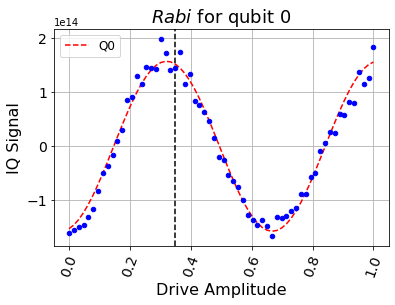

In [27]:
pi_amp = rabifit.pi_amplitude(0)

rabifit.plot(0)
print('Pi Amp: %f'%pi_amplitude)

# Simulator redux

## Run the same experiments on the simulator

Next, we run the same experiments on the pulse simulator. This section demonstrates the use of the `PulseSystemModel.from_backend` function for generating `PulseSystemModel` objects from a backend. 

**Note:** As the Hamiltonian parameters in `ibmq_armonk` are not yet fully populated, for now we need to insert parameters by hand.

In [31]:
# A value to use if previous cells of notebook were not run
# pi_amp = 0.326922

# Infer the value of the drive strength from the pi pulse amplitude:

# size of sample width for ibmq_armonk
dt = getattr(armonk_backend.configuration(), 'dt')
# array of samples for the amplitude 1 Gaussian pulse used in rabi experiments
sample_array = pulse_lib.gaussian(duration=drive_duration, amp=1, sigma=drive_sigma).samples
# area under the pulse
A = sum(sample_array*dt)
# Inferred value of drive strength
omegad0 = np.real(np.pi/(pi_amp*A*2))

# set omegad0 in backend object
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = omegad0
# set the qubit frequency from the estimate in the defaults
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = getattr(armonk_backend.defaults(), 'qubit_freq_est')[0]

Construct a `PulseSystemModel` object from the backend, and instantiate the simulator.

In [32]:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

backend_sim = PulseSimulator()

Assemble schedules as before, but now use `PulseSimulator` as the backend, and set `qubit_lo_freq` to the qubit frequency as determined by the Hamiltonian.

In [33]:
qubit_lo_freq = armonk_model.hamiltonian.get_qubit_lo_from_drift()

rabi_qobj_sim = assemble(rabi_scheds, 
                         backend=backend_sim, 
                         qubit_lo_freq=qubit_lo_freq,
                         meas_level=1, 
                         meas_return='avg', 
                         shots=shots)

Run the simulation and get the results.

In [34]:
sim_result = backend_sim.run(rabi_qobj_sim, armonk_model).result()

Generate the same plot.

In [37]:
rabifit = RabiFitter(sim_result, xdata, qubits, 
                           fit_p0 = [1.5, 2, 0, 0])

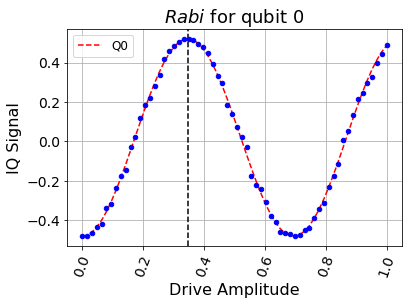

In [38]:
rabifit.plot(0)

# Rabi oscillations on `ibmq_armonk` backend

First, we run a Rabi experiment on the `ibmq_armonk` backend. This section is a reproduction of the [calibrating a qubit](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/1a_calibrating_a_qubit.ipynb) Ignis tutorial.

Get the `ibmq_armonk` backend:

In [4]:
provider = IBMQ.load_account()
armonk_backend = provider.get_backend('ibmq_armonk')

Set up the Rabi experiments, and `assemble` the `qobj`.

In [5]:
defaults = armonk_backend.defaults()
config = armonk_backend.configuration()

circ_inst_map = defaults.instruction_schedule_map

measure = circ_inst_map.get('measure', qubits=config.meas_map[0])

# qubit to use for experiment
qubit = 0

# exp configuration
exps = 64
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 1.0, exps)
drive_samples = 2048
drive_sigma = 256

# scaling factor for data returned by backend
# note: You may have to adjust this for the backend you use
scale_factor=1e-10

# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule |= rabi_pulse(pulse.DriveChannel(qubit))
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)
    
rabi_qobj = assemble(schedules, 
                     backend=armonk_backend, 
                     meas_level=MeasLevel.KERNELED, 
                     meas_return=MeasReturnType.AVERAGE, 
                     shots=shots)

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/models/pulsedefaults.py:155: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '
/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:377: UserWarning: `rep_time` now has units of seconds(s) rather than microseconds(mu s).
  warnings.warn('`rep_time` now has units of seconds(s) rather '


Run the job

In [6]:
# old job that has already run
job = armonk_backend.retrieve_job('5e336bc60491ec00187ace92')
#job = armonk_backend.run(rabi_qobj)

Check status

In [7]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

Get the results

In [8]:
rabi_result = job.result(timeout=3600)

Plot and fit the data

Pi Amplitude 0.324962


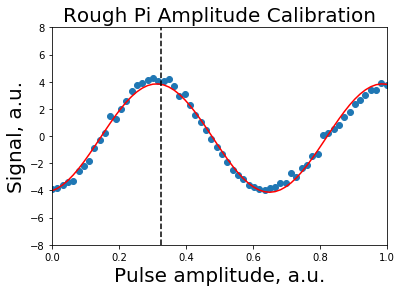

In [9]:
# extract the data
qubit_rabi_data = np.ones(exps, dtype=np.complex_)
for i in range(exps):
    qubit_rabi_data[i] = rabi_result.get_memory(i)[qubit]*scale_factor

# function for getting signal amplitude
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)    

rabi_amp_data = get_amplitude(qubit_rabi_data)

# fit the data
fit_func = lambda x,A,B,Omega,phi: (A*np.cos(2*np.pi*x/Omega+phi)+B)
fitparams, conv = curve_fit(fit_func, drive_amps, rabi_amp_data, [7.0,0.0,1.0,0.3])

# get the pi amplitude
pi_amp = (np.pi-fitparams[3])*fitparams[2]/4/np.pi

# plot
plt.scatter(drive_amps, rabi_amp_data)
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.xlim(0, 1)
plt.ylim(-8, 8)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)

print('Pi Amplitude %f'%(pi_amp))

## Run the same experiments on the simulator

Next, we run the same experiments on the pulse simulator. This section demonstrates the use of the `PulseSystemModel.from_backend` function for generating `PulseSystemModel` objects from a backend. 

**Note:** As the Hamiltonian parameters in `ibmq_armonk` are not yet fully populated, for now we need to insert parameters by hand.

In [10]:
# A value to use if previous cells of notebook were not run
# pi_amp = 0.326922

# Infer the value of the drive strength from the pi pulse amplitude:

# size of sample width for ibmq_armonk
dt = getattr(armonk_backend.configuration(), 'dt')
# array of samples for the amplitude 1 Gaussian pulse used in rabi experiments
sample_array = pulse_lib.gaussian(duration=drive_samples, amp=1, sigma=drive_sigma).samples
# area under the pulse
A = sum(sample_array*dt)
# Inferred value of drive strength
omegad0 = np.real(np.pi/(pi_amp*A*2))

# set omegad0 in backend object
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = omegad0
# set the qubit frequency from the estimate in the defaults
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = getattr(armonk_backend.defaults(), 'qubit_freq_est')[0]

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:355: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


Construct a `PulseSystemModel` object from the backend, and instantiate the simulator.

In [11]:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

backend_sim = PulseSimulator()

Assemble schedules as before, but now use `PulseSimulator` as the backend, and set `qubit_lo_freq` to the qubit frequency as determined by the Hamiltonian.

In [12]:
qubit_lo_freq = armonk_model.hamiltonian.get_qubit_lo_from_drift()

rabi_qobj_sim = assemble(schedules, 
                         backend=backend_sim, 
                         qubit_lo_freq=qubit_lo_freq,
                         meas_level=1, 
                         meas_return='avg', 
                         shots=shots)

Run the simulation and get the results.

In [13]:
sim_result = backend_sim.run(rabi_qobj_sim, armonk_model).result()

Generate the same plot.

Text(0.5, 1.0, 'Rough Pi Amplitude Calibration')

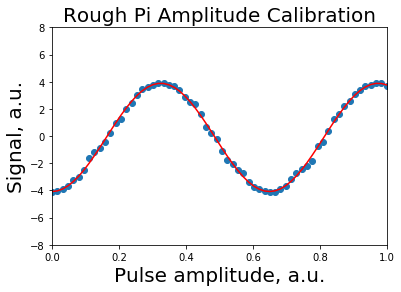

In [14]:
# set the scale factor to 8 to get the same data limits as the armonk backend
scale_factor = 8

# extract data
qubit_rabi_data = np.ones(exps, dtype=np.complex_)
for i in range(exps):
    qubit_rabi_data[i] = sim_result.get_memory(i)[qubit] * scale_factor

sim_amp_data = get_amplitude(qubit_rabi_data)

# fit the data
fit_func = lambda x,A,B,Omega,phi: (A*np.cos(2*np.pi*x/Omega + phi)+B)
fitparams, conv = curve_fit(fit_func, drive_amps, sim_amp_data, [0,0,1,0])

# plot
plt.scatter(drive_amps, sim_amp_data)
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
plt.xlim(0, 1)
plt.ylim(-8, 8)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)

Observe: the simulated results reproduce the oscillations of the device.

In [17]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright